# Conformal Geometry

Conformal geometry studies *conformal structures*, or, *conformal trasnformations*.
Topology is concerned with preserving connectivity (e.g. number of holes), while
conformal geometry is concerned with preserving angles.
Note that "conformity" is a stronger notion than topology, in the sense
that a conformal equivalence implies topological equivalence.

When modelling geometric objects, we can deal with different levels of abstraction. For example,
if we want to create a type "Triangle" that encapsulates all triangles, what is the "correct" equivalence
class to use for such modelling? We know that, from the start, a triangle has three vertices with v1
connected to v2, v2 connected to v3 and v1. From an topological perspective, this view is yet lacking. We don't
know if the triangle is filled or not, hence, it could either have one hole or zero holes. For our case,
let's suppose that a triangle is filled, i.e. it's a simpicial complex of $[v1,v2,v3,[v1,v2], [v2,v3],[v3,v1],[v1,v2,v3]]$.
Once this is defined, then we've characterized triangles topologically. Yet, note that, topologically, a triangle is the same
as a filled circle. Hence, the topology does not actually capture the "shape" of the triangle. This is done with
conformal equivalence.

Hence, besides the simplicial complex description (which is the algebraic topology), we need an algebraic conformal description.
This will be done using Geometric Algebra with the Conformal Model.


## 1. Conformal Algebra

Our goal is to model 3D space in a way that conformal transformations can be algebraically represented. Besides the algebraic
representation, we want our transformations to be covariant, in the sense that applying one conformal transformation preserves
the algebraic structure of our object.

"All conformal transformations are generated by versor products using the elementary
vectors of the conformal model... The fact that the general conformal transformations can be represented as versors ﬁnally
explains the name of the conformal model." (Leo Dorst, Geometric Algebra for Computer Science).

A conformal transformation is a map that locally preserves angles. This is of interest to us! Why?
Because the idea of constructing a diagram is that it's construction describes the shapes, yet,
lengths, locations, colors can change. For example, we want to define what a triangle is by specifying that
it has 3 vertices and 3 faces. Yet, this triangle might be rotated, translated, enlarged, and so on.

In [692]:
using Pkg, Revise
Pkg.activate("../.")

  Activating project at `~/MEGA/EMAP/Diagrams.jl`


In [693]:
using CliffordAlgebras
import CliffordAlgebras: basegrade
using LinearAlgebra: norm, normalize, dot
using Plots

coord(a::MultiVector) = a.e1 * cl.e1  + a.e2 * cl.e2 + a.e3* cl.e3

function getgradesdict(cl::CliffordAlgebra)
    gradesdict = Dict(g =>[] for g in 0:sum(signature(cl)))
    ngrades = sum(signature(cl))
    for g in 0:ngrades
        for (i,p) in enumerate(propertynames(cl))
            if i <= sum(binomial.(dimcl,0:g))
                push!(gradesdict[g],p)
            end
        end
    end

    return gradesdict
end

function Base.:≈(a::MultiVector,b::MultiVector)
    vector(a) ≈ vector(b)
end

function multivector(cl::CliffordAlgebra,v::Vector)
    bases = propertynames(cl)
    mapreduce(x->x[1] * getproperty(cl,x[2]),+, zip(v,bases))
end

function Base.map(f, c::MultiVector)
    multivector(algebra(c),map(f, vector(c)))
end

function Base.reduce(op, c::MultiVector)
    reduce(op, vectorize(c))
end

"""
vectorize(c::MultiVector)

Turns a multivector into a vector of multivectors,
where each element in a multivector with a single blade.
"""
function vectorize(c::MultiVector)
    filter(x->!isapprox(norm_sqr(x),0),basevector.(Ref(algebra(c)), propertynames(c)) .* vector(c))
end

"""
unvectorize(c::MultiVector)

Turns a vector of multivectors into a multivector by
summing each component.
"""
function unvectorize(c::MultiVector)
    reduce(+,vectorize(B))
end

"""
basesfromgrade(cl::CliffordAlgebra, k::Int)

Returns a list of base multivector for a given
grade `k`. Note that grades go from ``0`` to ``n``, 
where ``n`` is the dimension, given by the sum of
the signature, e.g. ``R^{3,1,1}`` has
``n = 5``.
"""
function basesfromgrade(cl::CliffordAlgebra, k::Int)
    ngrades = sum(signature(cl))
    i = sum(binomial.(ngrades,0:k-1))+1
    j = sum(binomial.(ngrades,0:k))
    basesymbol.(Ref(cl),i:j)
end


function norm_corr(a::MultiVector)
    sqrt(abs(norm_sqr(a)))
end


bladenormalization(B::MultiVector) = B / norm_corr(B)
orthogonalproj(c::MultiVector, B::MultiVector) = (c ⨼ B) * inv(B)
orthogonalreject(a::MultiVector, B::MultiVector) = (a ∧ B) ⨽ inv(B)

"""
maxgrade(A::MultiVector)

Returns the maximum grade ``k`` of a multivector A
with non-null value, i.e. ``\\langle A \\rangle_{max}``
is equal to `grade(A,maxgrade(A))`.
"""
function maxgrade(A::MultiVector)
    D = sum(signature(algebra(A)))
    i = findlast(!isapprox(0), norm_sqr(grade(A,k)) for k in 0:D)
    if isnothing(i)
        return 0
    end
    return i - 1
end
"""
mingrade(A::MultiVector)

Returns the minimum grade ``k`` of a multivector A
with non-null value, or returns 0.
"""
function mingrade(A::MultiVector)
    D = sum(signature(algebra(A)))
    i = findfirst(!isapprox(0), norm_sqr(grade(A,k)) for k in 0:D)
    if isnothing(i)
        return 0
    end
    return i - 1
end


function norm_corr(a::MultiVector)
    sqrt(abs(norm_sqr(a)))
end

bladenormalization(B::MultiVector) = B / norm_corr(B)
orthogonalproj(c::MultiVector, B::MultiVector) = (c ⨼ B) * inv(B)
orthogonalreject(a::MultiVector, B::MultiVector) = (a ∧ B) ⨽ inv(B)

function findmaxmv(f, a::MultiVector)
    cl = algebra(a)
    scalar, base = findmax(f,vector(a))
    return scalar * basevector(cl, base)
end

function deltaproduct(A::MultiVector,B::MultiVector)
    C = A*B
    return grade(C, maxgrade(C))
end

function span(a::MultiVector)
    if length(coefficients(a)) != 1
        error("This function takes only multivectors with a single coeffient")
    end
    if mingrade(a) ≤ 1
        return [a/norm(a)]
    end
    cl = algebra(a)
    A  = a / norm(a)
    b = []
    for e in basevector.(Ref(cl),basesfromgrade(cl,1))
        if !(norm_sqr(A ⋅ e) ≈ 0)
            push!(b, e)
        end
    end
    return b
end

"""
factorizeblade(B::MultiVector)

It takes a blade as input and factorizes it,
i.e. B = f1 ∧ f2 ∧... ∧fk
"""
function factorizeblade(B::MultiVector)
    s = norm_corr(B)
    temp = bladenormalization(B)
    mask = basevector.(Ref(algebra(B)),basesfromgrade(algebra(B),1))
    k    = mingrade(B)
    nfactors = 1
    factors  = []
    
    for i in nfactors:k-1
        for ej in mask
            proj = orthogonalproj(ej, temp)
            if !isapprox(norm_corr(proj),0.0; atol=1e-10)
                factorj = bladenormalization(proj)
                temp = inv(factorj) ⨼ temp
                push!(factors, factorj)
                break
            end
        end
    end
    factork = bladenormalization(temp)
    push!(factors, factork)
    return s, factors
end

function intersectionunionblades(a::MultiVector, b::MultiVector)
    cl = algebra(a)
    A = a
    B = b
    r = mingrade(a)
    s = mingrade(b)
    if r > s
        A = b
        B = a
    end
    delta = deltaproduct(A,B)
    t = Int((r + s - mingrade(delta))/2)
    s,factors = factorizeblade(dual(delta))
    inter = cl.𝟏
    uniao = pseudoscalar(cl)
    for factor in factors
        proj = orthogonalproj(factor,A)
        if !isapprox(norm_sqr(proj),0)
            inter = inter ∧ proj
            if mingrade(inter) == t
                uniao = (A ⨽ inv(inter)) ∧ B
                break
            end
        end
        
        reje = orthogonalreject(factor,A)
        # reje = factor - proj
        if !isapprox(norm_sqr(reje),0)
            uniao = reje ⨼ uniao
            if mingrade(uniao) == r + s - t
                inter = dual(B) ⨼ A
                break
            end
        end
    end
    
    if r > s
        uniao = uniao * (-1)^((r-t)*(s-t))
        inter = inter * (-1)^((r-t)*(s-t))
    end
    return inter, uniao
end

function meet(a::MultiVector, b::MultiVector)
    return dual(dual(a) ∧ dual(b))

end

# function union(a::MultiVector, b::MultiVector)
#     _, un = intersectionunionblades(a,b)
#     return un
# end

function roundmv(a::MultiVector,d::Int=4)
    map(x->round(x,digits=d),a)
end

roundmv (generic function with 2 methods)

## Bases - Metric

In conformal geometry, our representational space is 

In [694]:
cl = CliffordAlgebra(:CGA3D)

𝟏  = cl.𝟏
e1 = cl.e1
e2 = cl.e2
e3 = cl.e3
e₊ = cl.e₊
e₋ = cl.e₋
I  = pseudoscalar(cl)

# no = (cl.e₊ + cl.e₋)/2
# n∞ = cl.e₋ - cl.e₊
no = cl.e₊ - cl.e₋
n∞ = cl.e₋ + cl.e₊

propertynames(cl)

(:𝟏, :e1, :e2, :e3, :e₊, :e₋, :e1e2, :e1e3, :e2e3, :e1e₊, :e2e₊, :e3e₊, :e1e₋, :e2e₋, :e3e₋, :e₊e₋, :e1e2e3, :e1e₊e2, :e1e3e₊, :e2e₊e3, :e1e2e₋, :e1e₋e3, :e2e3e₋, :e1e₊e₋, :e2e₋e₊, :e3e₊e₋, :e1e2e3e₊, :e1e2e₋e3, :e1e2e₊e₋, :e1e3e₋e₊, :e2e3e₊e₋, :e1e2e3e₊e₋)

In [695]:
@show e₊ ⋅ e₋
@show e₊ ⋅ e₊
@show no ⋅ n∞
@show no ⋅ no
@show n∞ ⋅ n∞;

e₊ ⋅ e₋ = 0
e₊ ⋅ e₊ = +1 ∈ Cl(4, 1, 0)
no ⋅ n∞ = +2 ∈ Cl(4, 1, 0)
no ⋅ no = 0
n∞ ⋅ n∞ = 0


## Points

In the conformal model, a finite unitary point is:
$$
p = n_0 + \alpha_1 e_1 + ... + \alpha_k e_k + \frac{1}{2} \sum^k_{i=1} \alpha_i^2 n_\infty
$$


In [696]:
# point(x=0,y=0,z=0)  = no + x*cl.e1 + y*cl.e2 + z*cl.e3 + (x^2 + y^2 + z^2)/2 * n∞
# point(;x=0,y=0,z=0) = no + x*cl.e1 + y*cl.e2 + z*cl.e3 + (x^2 + y^2 + z^2)/2 * n∞
point(x=0,y=0,z=0)  = -no/2 + x*cl.e1 + y*cl.e2 + z*cl.e3 + (x^2 + y^2 + z^2)/2 * n∞
point(;x=0,y=0,z=0) = -no/2 + x*cl.e1 + y*cl.e2 + z*cl.e3 + (x^2 + y^2 + z^2)/2 * n∞

struct Point
    mv::MultiVector
    Point(mv) = new(point(mv))
end
Point(a,b) = Point(point(a,b))
Point(a,b,c) = Point(point(a,b,c))

struct Line
    mv::MultiVector
    Line(a::Point,b::Point) = new(bladenormalization(a.mv ∧ b.mv ∧ n∞))
end

plotmv(x::MultiVector,l="x";kwargs...) = scatter([x.e1],[x.e2],label=l)
plotmv!(x::MultiVector,l="x";kwargs...) = scatter!([x.e1],[x.e2],label=l)

Line(Point(0), Point(1)).mv

+1.0×e1e₊e₋ ∈ Cl(4, 1, 0)

A pair of points is modeled as a blade $p_1 \wedge p_2$.
Hence, given a pair of points, we need a way of extracting them.

In [697]:
p1 = point(1,2,3)
p2 = point(1,10,10)
B  = p1 ∧ p2
β = √scalar(B*B)

F = B/β

roundmv(F*F)
P = (1+F)/2
P̃ = (1-F)/2

@show P*P ≈ P
@show scalar(P*P̃) ≈ 0;

@show -P̃*(B ⋅ n∞) ≈ p1;
@show P*(B ⋅ n∞) ≈ p2

P * P ≈ P = true
scalar(P * P̃) ≈ 0 = true
-P̃ * (B ⋅ n∞) ≈ p1 = true
P * (B ⋅ n∞) ≈ p2 = true


true

## Circle and Sphere

In [698]:
p1 = point(1,0,0)
p2 = point(0,1,0)
p3 = point(-1,0,0)

c = p1 ∧ p2 ∧ p3


function sphere(center = [0,0,0], radius = 1)
    p1 = point((center + [radius,0,0])...)
    p2 = point((center + [-radius,0,0])...)
    p3 = point((center + [0,radius,0])...)
    p4 = point((center + [0,0,radius])...)
    
    bladenormalization(p1 ∧ p2 ∧ p3 ∧ p4)
end

# # d = direction
# function circle(c=[0,0,0], r=1, d=[1,0,0])
#     d̂ = r*d/norm(d)
#     p1 = point((center + d̂)...)
#     p2 = point((center - d̂)...)
#     p2 = point((center + [-radius,0,0])...)
#     p3 = point((center + [0,radius,0])...)
# end

sphere (generic function with 3 methods)

In [699]:
α = 2
Dα = exp(α/2*cl.e₊*cl.e₋)

+1.5430806348152437+1.1752011936438014×e₊e₋ ∈ Cl(4, 1, 0)

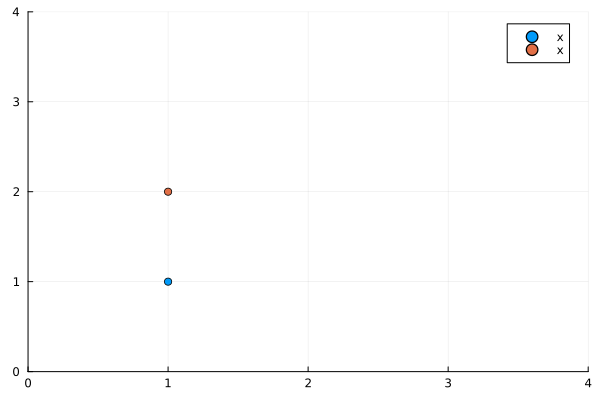

In [700]:
translate(t::Vector) = 1 - (t[1]cl.e1 + t[2]cl.e2 + t[3]cl.e3)*n∞/2

d = [0,1,0]
Td = translate(d)
x = point(1,1)
y = Td * x * ~(Td)


z = Dα  * x * ~(Dα)

plotmv(x)
plotmv!(y)
xlims!(0,4)
ylims!(0,4)

In [701]:
inversion(x) = -cl.e₊ * x * cl.e₊


inversion(n∞) == -no

true

In [702]:
scalar(z ⋅ n∞) ≈ -exp(2)

coord(z)

+1.0000000000000002×e1+1.0000000000000002×e2 ∈ Cl(4, 1, 0)

In [703]:
point

point (generic function with 4 methods)

In [704]:
Ic = n∞ ∧ c/√abs(scalar((n∞ ∧ c)*(n∞ ∧ c)))
dual(c)

c * Ic

-2.0×e₊ ∈ Cl(4, 1, 0)

In [705]:
c*n∞*c

-4.0×e₊+4.0×e₋ ∈ Cl(4, 1, 0)

In [706]:
dual(l2)

+1.0×e2e3-2.0×e3e₊+2.0×e3e₋ ∈ Cl(4, 1, 0)

# Rotations

In [707]:
a = point()
b = point(1,1)
l1 = bladenormalization(a ∧ b ∧ n∞)

c = point(0,2)
d = point(2,2)
l2 = bladenormalization(c ∧ d ∧ n∞)


x = point(2,2)

+2.0×e1+2.0×e2+3.5×e₊+4.5×e₋ ∈ Cl(4, 1, 0)

In [708]:
# x4 = (l1_*point(2,3)*l1_ + point(2,3))/2

meet(l1,l2)

function sphere(center = [0,0,0], radius = 1)
    p1 = point((center + [radius,0,0])...)
    p2 = point((center + [-radius,0,0])...)
    p3 = point((center + [0,radius,0])...)
    p4 = point((center + [0,0,radius])...)
    
    bladenormalization(p1 ∧ p2 ∧ p3 ∧ p4)
end

sphere()

-1.0×e1e2e₋e3 ∈ Cl(4, 1, 0)

In [709]:
c = bladenormalization(point(1,0,0) ∧ point(-1,0,0) ∧ point(0,1,0))

Ic = bladenormalization(c ∧ n∞)
s  = c * Ic * I

+1.0×e1e2e₋e3 ∈ Cl(4, 1, 0)

In [710]:
bladenormalization(point(1,0,0) ∧ point(-1,0,0) ∧ point(0,1,0) ∧ point(0,0,1))

-1.0×e1e2e₋e3 ∈ Cl(4, 1, 0)

In [711]:
s * n∞ * s

ρ = (s*s)/((s ∧ n∞)*(s ∧ n∞))

+1.0 ∈ Cl(4, 1, 0)

In [712]:
meet(s,l1)
# meet(c,l1)

-0.7071067811865475×e1e₋-0.7071067811865475×e2e₋ ∈ Cl(4, 1, 0)

In [713]:
# Without blade normalizaion for the line, the x1,x2 and x3 points are not correctly reflected
# but, the final intersection point p is still reflected correctly.
l1_ = l1 - l2*l1*l2
l1_ = bladenormalization(l1 - l2*l1*l2)
x = no
x1 = l1_ * x * l1_
x2 = (x+x1)/2

x3 = l2 * x2 * l2

p_ = (x2 + x3)/2
p  = -(p_* n∞ * p_) / (2(p_ ⋅ n∞)*(p_ ⋅ n∞))


+2.0×e1+2.0×e2+3.5×e₊+4.5×e₋ ∈ Cl(4, 1, 0)

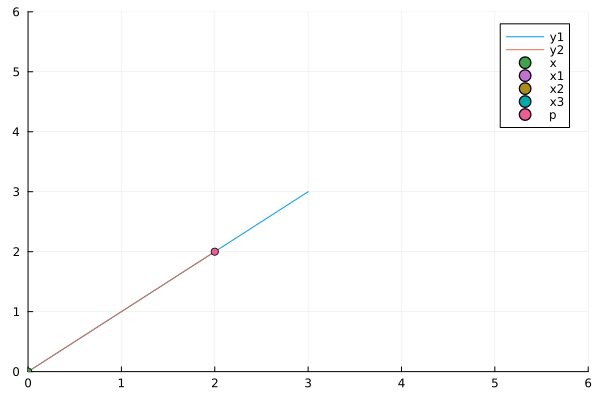

In [714]:
plot([a.e1,3],[a.e2,3])
plot!([c.e1,d.e1],[c.e2,d.e2])
plotmv!(x,"x")
plotmv!(x1,"x1")
plotmv!(x2,"x2")
plotmv!(x3,"x3")
plotmv!(p,"p")


xlims!(0,6)
ylims!(0,6)

In [385]:
n = 5
r = maxgrade(l1)
s = maxgrade(l2)
g = 2n - r - s

4

In [261]:
l1*l1

+0.9999999999999998 ∈ Cl(4, 1, 0)

In [262]:
x ∧ (l1 + l2)

+1.0×e1e2e₊e₋ ∈ Cl(4, 1, 0)

In [263]:
# no = (-cl.e₊ + cl.e₋)/2
# n∞ = cl.e₋ + cl.e₊

line = bladenormalization(point(2) ∧ point(2,0,1) ∧ n∞)

a = point(0,0,1)
b = point(1,0,1)
c = point(0,1,1)
plane = bladenormalization(a ∧ b ∧ c ∧ n∞)

m = map(x->round(x,digits=10),meet(line,plane))

+4.0×e1e3-18.0×e1e₊-7.0×e3e₊-18.0×e1e₋-9.0×e3e₋+9.0×e₊e₋ ∈ Cl(4, 1, 0)

In [264]:
(I*line) ⨼ plane

-2.0×e1e₊-1.0×e3e₊-2.0×e1e₋-1.0×e3e₋+1.0×e₊e₋ ∈ Cl(4, 1, 0)

In [265]:
# I*((I*line)∧ (I*line)) == dual(dual(plane) ∧ dual(line))

In [ ]:
s, factors = factorizeblade(line)
s*reduce(∧,factors) ≈ line

In [ ]:
dual(dual(line) ∧ dual(plane))

In [ ]:
line

In [ ]:
plane

In [ ]:
# meet(line,plane)

In [ ]:
m

In [ ]:
# grade(l1*l2,5
n = sum(signature(cl))
r = mingrade(l1)
s = mingrade(l2)

# grade(l1*l2, 2n - r - s)
l1*l2

In [ ]:
a ∧ b ∧ n∞

In [683]:
fc.(cp)

158-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [0.9968017063026193, 0.07991469396917268]
 [0.9872272833756272, 0.15931820661424598]
 [0.9713379748520297, 0.23770262642713458]
 [0.9492354180824408, 0.31456656061611776]
 [0.9210609940028851, 0.38941834230865047]
 [0.886994922779284, 0.46177917554148284]
 [0.847255111013416, 0.5311861979208834]
 [0.8020957578842925, 0.597195441362392]
 [0.7518057291408949, 0.6593846719714731]
 [0.6967067093471655, 0.7173560908995228]
 [0.6371511441985801, 0.7707388788989693]
 [0.5735199860724566, 0.8191915683009982]
 ⋮
 [0.6322281679828088, -0.7747822556106337]
 [0.692122603467712, -0.721779953842635]
 [0.7475898162316444, -0.6641607235200951]
 [0.7982750054006176, -0.6022931310853911]
 [0.8438539587324919, -0.5365729180004349]
 [0.8840351264689191, -0.467420469351827]
 [0.9185614862588487, -0.39527812482090974]
 [0.9472121872244621, -0.32060734921933826]
 [0.9698039626531111, -0.24388578068908245]
 [0.9861923022788637, -0.16560417544830938]
 [0.996272

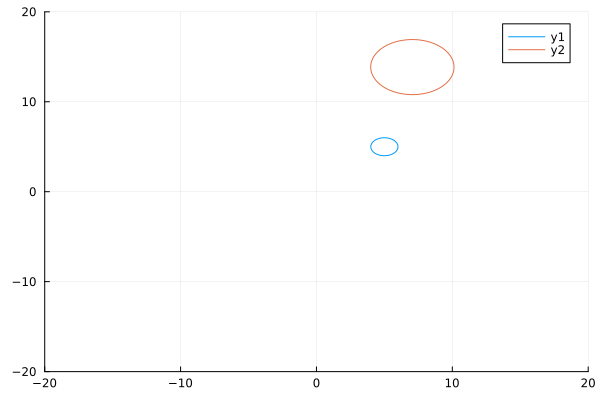

In [690]:
circle(θ) = [cos(θ) , sin(θ)] + [5,5]

complexify(v) = v[1] + v[2]im
decomplexify(c) = [c.re, c.im]
f(z) = z^1.4
fc(v) = (decomplexify ∘ f ∘ complexify)(v)

cp = circle.(0:0.04:2π)
c = hcat([v[1] for v in cp],[v[2] for v in cp])
cf = hcat([v[1] for v in (fc ∘ circle).(0:0.04:2π)],[v[2] for v in (fc ∘ circle).(0:0.04:2π)])

plot(c[:,1],c[:,2])
plot!(cf[:,1],cf[:,2])
xlims!(-20,20)
ylims!(-20,20)

158×2 Matrix{Float64}:
 1.0        0.0
 0.9992     0.0399893
 0.996802   0.0799147
 0.992809   0.119712
 0.987227   0.159318
 0.980067   0.198669
 0.971338   0.237703
 0.961055   0.276356
 0.949235   0.314567
 0.935897   0.352274
 0.921061   0.389418
 0.904752   0.425939
 0.886995   0.461779
 ⋮         
 0.90339   -0.428819
 0.919816  -0.39235
 0.93477   -0.355254
 0.948229  -0.317589
 0.96017   -0.279415
 0.970576  -0.240795
 0.979429  -0.20179
 0.986715  -0.162462
 0.992422  -0.122874
 0.996542  -0.0830894
 0.999068  -0.0431719
 0.999995  -0.0031853